In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import SpectralClustering
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv

In [2]:
patient_icd_sparse_path = "./../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p"
pdata = pickle.load(open(patient_icd_sparse_path, "rb"))
pdata.shape

(46520, 6984)

In [3]:
x = np.array([[4, 0, 0],[0,4,0],[0,0,4]])
np.sqrt(np.linalg.inv(x))

array([[0.5, 0. , 0. ],
       [0. , 0.5, 0. ],
       [0. , 0. , 0.5]])

In [4]:
#Build L Matrix
ANNOY_PATH = "../../../large_data_files"
annoy_path = os.path.join(ANNOY_PATH, "200214_patient_similarity_clusters_default.ann")

cos_knn_tree = AnnoyIndex(pdata.shape[1], "angular")
cos_knn_tree.load(annoy_path)
k_neighbors = 50
k_neighbors += 1

gamma = 2
print("Building dense data matrix with k={} nn...".format(k_neighbors))
A = np.zeros((pdata.shape[0], pdata.shape[0]))
D = np.zeros((pdata.shape[0], pdata.shape[0]))
for i in tqdm(range(pdata.shape[0])):
    nn_idxs = cos_knn_tree.get_nns_by_item(i, k_neighbors)[1:]
    cos_distances = [cos_knn_tree.get_distance(i, nn) for nn in nn_idxs]
    rbf_distances = [np.exp(-gamma*cos_dist**2) for cos_dist in cos_distances]
    D[i, i] = np.sum(rbf_distances)
    A[i, nn_idxs] = rbf_distances

  0%|          | 3/46520 [00:00<29:26, 26.33it/s]

Building dense data matrix with k=51 nn...


100%|██████████| 46520/46520 [10:06<00:00, 76.71it/s]


In [ ]:
print("Finishing matrix operations...")
D_sqrt = np.sqrt(D)
print("Inverting matrix...")
D_sqrt_inv = np.linalg.inv(D_sqrt)
print("Multiplying matrices...")
L = D_sqrt_inv @ A @ D_sqrt_inv
print("sparsifying matrix...")
L_sparse = csr_matrix(L)
L_sparse.shape

In [5]:
pickle.dump(csr_matrix(A), open("A_K{}_CSR.p".format(k_neighbors - 1), "wb"))
pickle.dump(csr_matrix(D), open("D_K{}_CSR.p".format(k_neighbors - 1), "wb"))

In [23]:
A = pickle.load(open("A_K{}_CSR.p".format(k_neighbors - 1), "rb"))
D = pickle.load(open("D_K{}_CSR.p".format(k_neighbors - 1), "rb"))

D_inv_sqrt = inv(D.sqrt())
pickle.dump(csr_matrix(D), open("D_inv_sqrt_K{}_CSR.p".format(k_neighbors - 1), "wb"))

In [24]:
print("computing L...")
L = D_inv_sqrt.multiply(A.multiply(D_inv_sqrt))
pickle.dump(csr_matrix(D), open("L_K{}_CSR.p".format(k_neighbors - 1), "wb"))

computing L...


In [6]:
k_neighbors = 50
k_neighbors += 1
L = pickle.load(open("L_K{}_CSR.p".format(k_neighbors - 1), "rb"))

In [7]:
unnormalized_data = L.toarray()
print(unnormalized_data.shape)
print("Std", np.std(unnormalized_data, axis=0))

(46520, 46520)


KeyboardInterrupt: 

In [ ]:
std_data = preprocessing.scale(unnormalized_data)

In [34]:
evals, evecs = np.linalg.eig(std_data)
pickle.dump(evals, open("evals_K{}_CSR.p".format(k_neighbors - 1), "rb"))

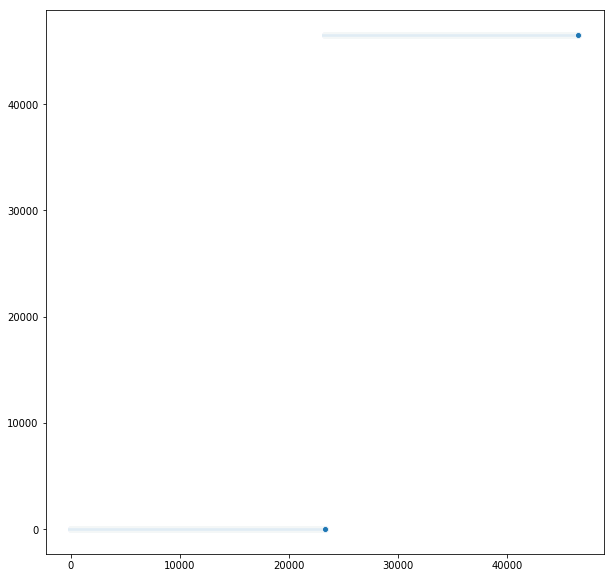

In [49]:
evals_threshed = evals[:]

plt.figure(figsize=(10,10))
sns.scatterplot(range(evals_threshed.shape[0]), evals_threshed)
plt.savefig("eigen_val_plots_K{}.png".format(k_neighbors - 1))

In [28]:
print(std_data[:10])

[[ 2.15682637e+02 -4.63644182e-03 -4.63644182e-03 ... -4.63644182e-03
  -4.63644182e-03 -4.63644182e-03]
 [-4.63644182e-03  2.15682637e+02 -4.63644182e-03 ... -4.63644182e-03
  -4.63644182e-03 -4.63644182e-03]
 [-4.63644182e-03 -4.63644182e-03  2.15682637e+02 ... -4.63644182e-03
  -4.63644182e-03 -4.63644182e-03]
 ...
 [-4.63644182e-03 -4.63644182e-03 -4.63644182e-03 ... -4.63644182e-03
  -4.63644182e-03 -4.63644182e-03]
 [-4.63644182e-03 -4.63644182e-03 -4.63644182e-03 ... -4.63644182e-03
  -4.63644182e-03 -4.63644182e-03]
 [-4.63644182e-03 -4.63644182e-03 -4.63644182e-03 ... -4.63644182e-03
  -4.63644182e-03 -4.63644182e-03]]


In [ ]:
gt1_subject_ids_path = "../../data/PATIENT_ICD_SUBJECT_IDS_GT1_VISITS.csv"
gt1_subject_ids = pd.read_csv(gt1_subject_ids_path)
gt1_idxs = gt1_subject_ids.MATRIX_ROW_IDX.values

patient_icd_sparse_path = "./../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p"
pdata_sparse = pickle.load(open(patient_icd_sparse_path, "rb"))
pdata_dense = pdata_sparse.toarray()

pdata_gt1 = pdata_dense[gt1_idxs]
pdata_gt1.shape

In [ ]:
print(np.sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

In [ ]:
%%timeit -n 1 -r 1
unnormalized_data = pdata_gt1
std_data = preprocessing.scale(unnormalized_data)

n_clusters = 5
sc = SpectralClustering(n_clusters=n_clusters).fit(std_data)
unique, counts = np.unique(sc.labels_, return_counts=True)
print(unique, counts)